# Webscrapping BoardGameGeek.com
## Project scope
In this project we set out to get a list of top 10 000 board games on BoardGameGeek (with links), and then use this list to scrap individual pages for more detailed info.  
## Execution
Scrapping the top list was fast because we were able to work using requests.get(). Scrapping the individual board games has proven more difficult. The website uses javascript to dynamically load the important part of the page, so using the simple requests.get() wasn't a success.   
To overcome this challenge, we needed to use a emulated browser to execute the JS code. We chose Selenium, because we had some experience with it during the previous semester. Since this process is much slower, we decided to scrap only 100 individual pages. We also didn't want to burden the server, but since BGG is a very popular website, the additional 1 000 visits probably wouldn’t make a difference anyway. 

# Scrapping the summary page
## Importing libraries

In [28]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from time import sleep
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Centering all plots by CSS

In [29]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Scrapping the top 10 000 games

In [130]:
headers = {'User-Agent': 'Animated Winter'}

#Create an empty dataframe to hold the results
summaryTable = pd.DataFrame()

# Each page has 100 boardgames, so we want to loop 100 times
for i in range(1,101):
    # Get the webpage
    r = requests.get('https://boardgamegeek.com/browse/boardgame/page/{}?sort=rank'.format(i), headers=headers)
    
    # Convert to BS
    bs = BeautifulSoup(r.text)
    
    # Find the right table
    table = bs.findAll(lambda tag: tag.name=='table' and tag.has_attr('cellpadding'))
    tableHTML = table[0]
    
    # Extract all the links
    urls = [np.where(tag.has_attr('href'),tag.get('href'),"no link") for tag in tableHTML.find_all('a')]
    urls = pd.DataFrame(urls)
    
    # Convert the HTML of the table to pandas (very usefull function)
    pandasTable = pd.read_html(str(tableHTML), header=0)[0]
    
    # Format the links
    urls[0] = urls[0].astype(str)
    urls = urls[urls[0].str.contains("/boardgame/")][1:]
    urls = urls[~urls[0].str.contains("/marketplace/")]
    
    # Remove any duplicates
    urls = pd.unique(urls[0])
    urls = pd.DataFrame(urls)
    
    # Merge the links into the DF
    pandasTable['link'] = urls
    
    # Drop unused columns
    pandasTable = pandasTable.drop(['Unnamed: 1', 'Shop'], axis = 1)
    
    # Create or extend the existing summary table
    if summaryTable.empty:
        summaryTable = pandasTable
    else:
        summaryTable = pd.concat([summaryTable, pandasTable],ignore_index=True)

## A summary of 10 000 most popular games on BoardGameGeek, with some basic stats.
To get the full link add https://boardgamegeek.com before the string.

In [18]:
display(summaryTable)

,Board Game Rank,Title,Geek Rating,Avg Rating,Num Voters,link
0,1,Gloomhaven (2017),8.608,8.90,24863,/boardgame/174430/gloomhaven
1,2,Pandemic Legacy: Season 1 (2015),8.488,8.64,31084,/boardgame/161936/pandemic-legacy-season-1
2,3,Through the Ages: A New Story of Civilization ...,8.258,8.53,15653,/boardgame/182028/through-ages-new-story-civil...
3,4,Terraforming Mars (2016),8.243,8.40,38741,/boardgame/167791/terraforming-mars
4,5,Twilight Struggle (2005),8.173,8.32,34385,/boardgame/12333/twilight-struggle
5,6,Star Wars: Rebellion (2016),8.164,8.45,16567,/boardgame/187645/star-wars-rebellion
6,7,Gaia Project (2017),8.121,8.54,9239,/boardgame/220308/gaia-project
7,8,Scythe (2016),8.120,8.29,39504,/boardgame/169786/scythe
8,9,Twilight Imperium (Fourth Edition) (2017),8.085,8.73,6670,/boardgame/233078/twilight-imperium-fourth-edi...
9,10,Great Western Trail (2016),8.081,8.29,19186,/boardgame/193738/great-western-trail


## Exporting the results 
For Python and Excel.

In [25]:
# For Python
summaryTable.to_pickle("Summary.p")

# For Excel
summaryTable.to_csv("Summary.csv", sep=';', decimal = ',')

# Scrapping the individual pages
This time we'll be using Selenium.

In [7]:
# Loading the firefox webdriver
driver = webdriver.Firefox()

In [11]:
# Construct the results table
detailedTable = pd.DataFrame(columns=['Title','Average Rating','Number of ratings','Std.dev','Complexity','Number of Comments','Fans','Page Views','Overall Ranking','All Time Plays','Played This Month', 'Own', 'Previously Owned','For Trade','Want in Trade','Wishlist','Has Parts','Want Parts'])
detailedTable2 = pd.DataFrame()

for j in range(100):
    # Load the webpage
    driver.get('https://boardgamegeek.com{}/stats'.format(summaryTable['link'][j]))
    
    # Get the source code and make it BS
    pageSource = driver.page_source
    bs = BeautifulSoup(pageSource, "lxml")
    
    # Find the relevant table
    data = bs.findAll('div',{'class':'outline-item-description'})
    
    # Loop over and strip spaces
    data2 = []
    for i in data:
        data2.append(i.get_text().strip())

    # Remove the ',' 
    for i in range(len(data2)):
        data2[i] = data2[i].replace(",","")

    # Wrangle the columns
    data2[3] = data2[3][0:4]
    data2[0] = float(data2[0])
    data2[1] = int(data2[1]) 
    data2[2] = float(data2[2])
    data2[3] = float(data2[3]) 

    # Convert to int
    for i in range(len(data2[4:])+1):
        i = i+3
        data2[i] = int(data2[i])

    # Special case - two categories. We want to drop both
    if len(data2) == 19:
        data2.pop(8)
        data2.pop(8)
    else:
        data2.pop(8)
    
    # Insert the data
    data2.insert(0,summaryTable['Title'][j]) 
    detailedTable.loc[len(detailedTable)] = data2

In [ ]:
## More detailed table
100 observations with 18 

In [26]:
# Now we have more to interpret - 18 columns
display(detailedTable)

,Title,Average Rating,Number of ratings,Std.dev,Complexity,Number of Comments,Fans,Page Views,Overall Ranking,All Time Plays,Played This Month,Own,Previously Owned,For Trade,Want in Trade,Wishlist,Has Parts,Want Parts
0,Gloomhaven (2017),8.901,24863,1.60,3,4937,4769,8121209,1,177562,2466,40792,1264,216,1344,12154,18,7
1,Pandemic Legacy: Season 1 (2015),8.642,31084,1.61,2,4959,2247,2822351,2,178979,664,49456,3194,238,780,8483,10,5
2,Through the Ages: A New Story of Civilization ...,8.533,15653,1.49,4,2282,1113,2235683,3,43742,386,19372,1085,250,1037,6436,6,4
3,Terraforming Mars (2016),8.403,38741,1.36,3,5856,3092,4120292,4,187454,3045,49782,1419,228,2068,12969,15,6
4,Twilight Struggle (2005),8.324,34385,1.59,3,7738,3726,4339022,5,89047,334,47302,3204,780,1342,8913,36,28
5,Star Wars: Rebellion (2016),8.447,16567,1.38,3,2681,1670,2746485,6,24705,170,25232,912,188,1350,7945,4,6
6,Gaia Project (2017),8.541,9239,1.43,4,1389,821,1345459,7,27821,461,11380,347,54,1214,6172,1,2
7,Scythe (2016),8.287,39504,1.43,3,6217,4264,5017886,8,124795,1295,51381,1703,300,1880,13293,27,10
8,Twilight Imperium (Fourth Edition) (2017),8.726,6670,1.57,4,1106,940,1310082,9,8916,162,9329,175,43,728,4857,0,1
9,Great Western Trail (2016),8.287,19186,1.25,3,2606,955,1645368,10,58428,714,23465,894,114,1626,6988,6,3


## Saving the data
Again, in Python pickle and in excel compatible CSV

In [27]:
# For Python
detailedTable.to_pickle("Detailed.p")

# For Excel
detailedTable.to_csv("Detailed.csv", sep=';', decimal = ',')

# Data analysis

## Converting variables
All variables (title excluding) has to be converted from objects to floats for graphs to work.  

In [83]:

cols = ["Average Rating", "Number of ratings", "Std.dev", 
        "Complexity", "Number of Comments", "Fans", "Page Views", 
        "Overall Ranking", "All Time Plays", "Played This Month", 
        "Own", "Previously Owned", "For Trade", "Want in Trade", 
        "Wishlist", "Has Parts", "Want Parts"]

for col in cols:
    detailedTable[col] = detailedTable[col].astype(float)

## How complex are games in the top 100? 
Mostly 3. There aren't many 1 or 4 complexity games in the top 100. Turns out that making the game to shallow or too complex can hurt its rating

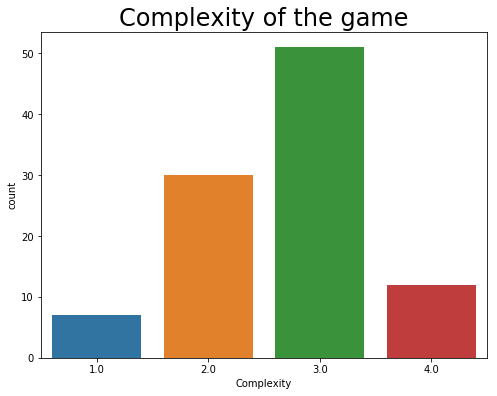

In [123]:
plt.figure(figsize=(8,6))
sns.countplot(detailedTable['Complexity'].astype('str').sort_values())
plt.title("Complexity of the game",fontsize=24)
plt.show()

## Let's take a first look at the data
There are some interesting patterns. The 'social' variables seem to be strongly correlated. Number of comments and number of ratings are highly correlated. This is because when you rate a game, you can post a comment at the same time.

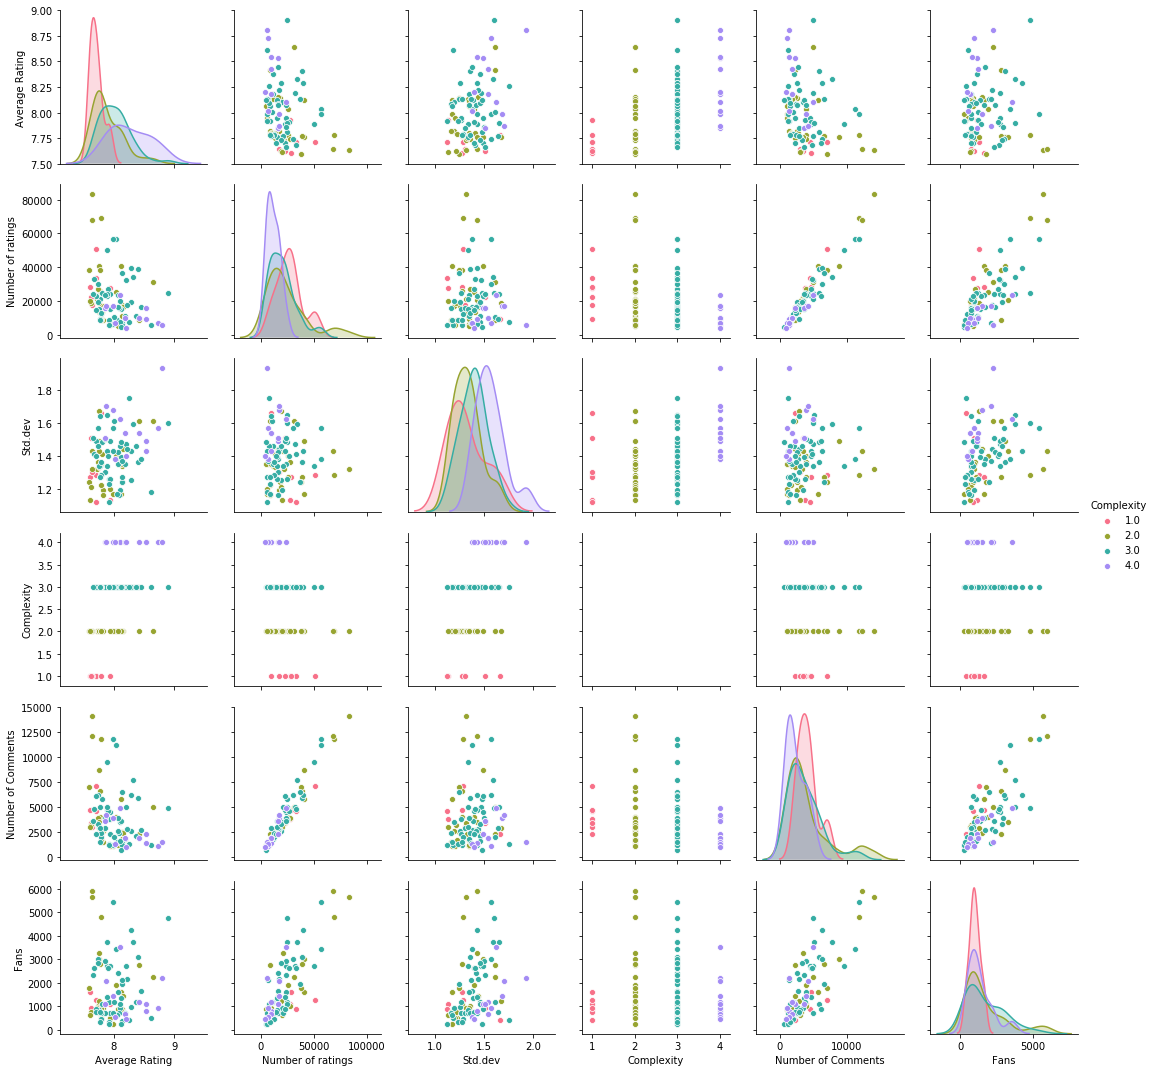

In [96]:
sns.pairplot(detailedTable[detailedTable.columns[1:7]], height = 2.5, hue="Complexity", palette="husl")

## We can see some patterns, let's examine the correlation matrix
As previously observed, there are many strong correlations (> 0.7). All of them are positively correlated, with the exception of Overall Ranking. This is because this variable is inverted - 1 means best, and 100 means worst.

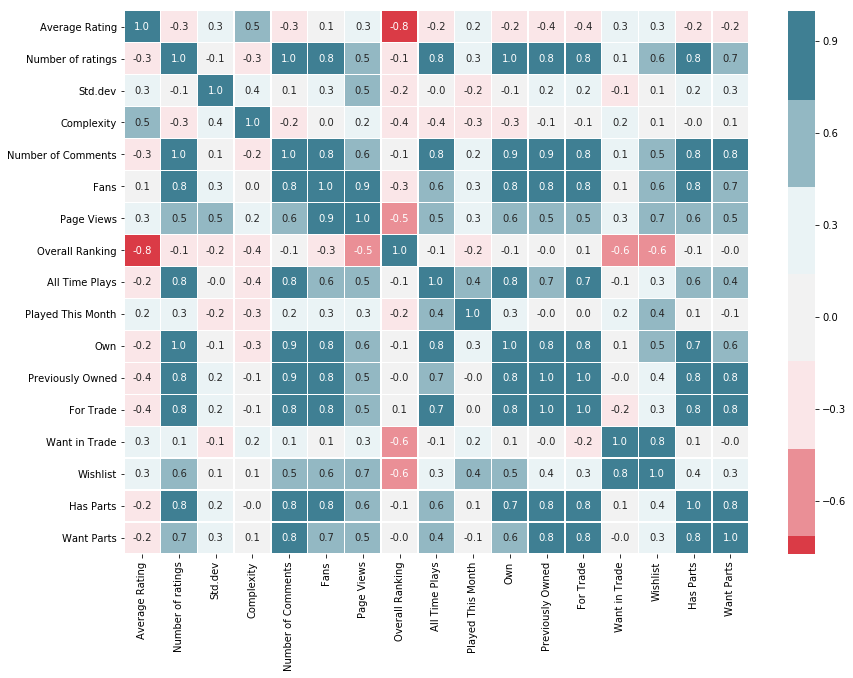

In [93]:
f,ax = plt.subplots(figsize=(14, 10))
palette = sns.diverging_palette(10, 220, sep=80, n=7)
sns.heatmap(detailedTable[detailedTable.columns[1:19]].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, center=0, cmap=palette)
plt.show()

## Finally, let's test some typical assumptions 
### Is the Ranking dependent on the Average rating? 
Yes, but there are some notable outliers, especially near 80 to 100 mark.

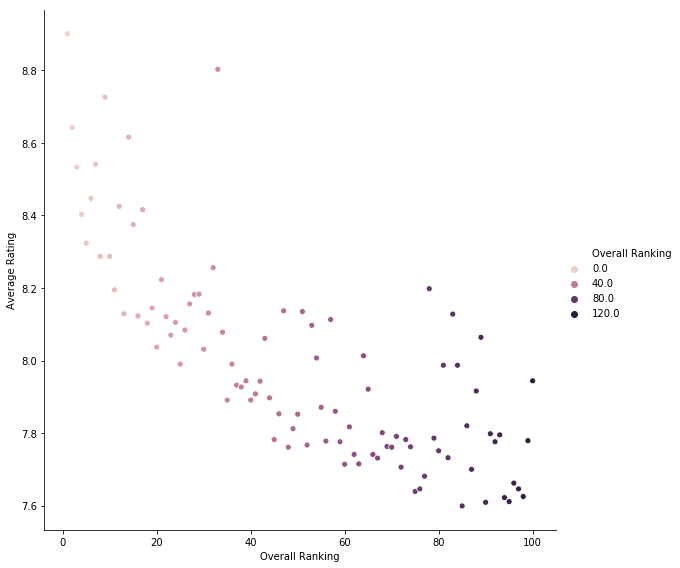

In [121]:
# Let's take a look at the Ranking vs Average Rating 
sns.relplot(x="Overall Ranking", y="Average Rating", data=detailedTable, height = 8, hue = 'Overall Ranking')

### Does the Ranking of the game depend on it's popularity?
Thankfully, no. BoardGameGeek does a good job of representing the good, but more niche titles.

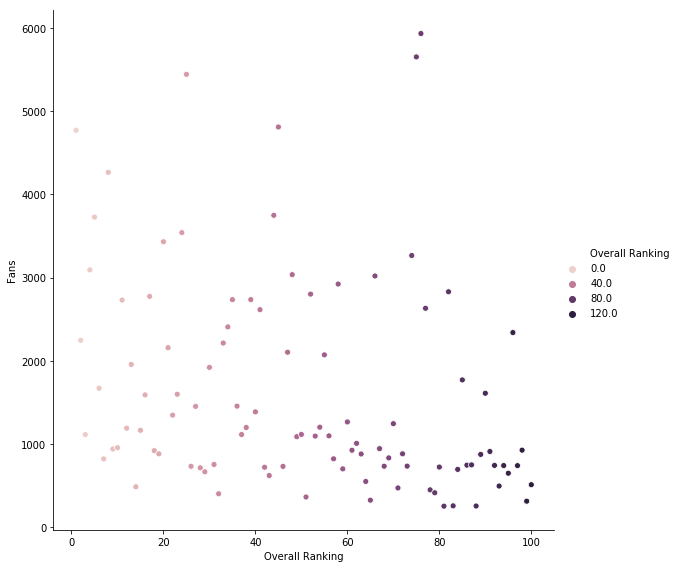

In [120]:
sns.relplot(x="Overall Ranking", y="Fans", data=detailedTable, height = 8, hue = 'Overall Ranking')

### Does the complexity of the game influence it's rating?
Turns out that yes, it does. Users seem to prefer more complex games (3 and 4). They particularly dislike the very simple 'party' games (complexity = 1).

G:\Aplikacje\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


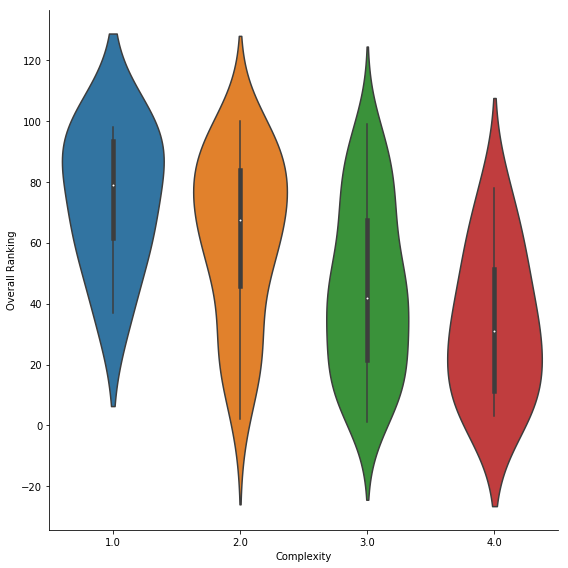

In [129]:
sns.catplot(x="Complexity", y="Overall Ranking", data=detailedTable, height = 8, kind="violin")